# pytorch 官方demo CIFAR10图像分类

In [21]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 50000张训练图片
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=36,
                                          shuffle=True, num_workers=0)

# 10000张验证图片
val_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=5000,
                                         shuffle=False, num_workers=0)
val_data_iter = iter(val_loader)
val_image, val_label = val_data_iter.next()


# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data


In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))    # input(3, 32, 32) output(16, 28, 28)
        x = self.pool1(x)            # output(16, 14, 14)
        x = F.relu(self.conv2(x))    # output(32, 10, 10)
        x = self.pool2(x)            # output(32, 5, 5)
        x = x.view(-1, 32*5*5)       # output(32*5*5)
        x = F.relu(self.fc1(x))      # output(120)
        x = F.relu(self.fc2(x))      # output(84)
        x = self.fc3(x)              # output(10)
        return x

In [8]:
net = LeNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if step % 500 == 499:    # print every 500 mini-batches
            with torch.no_grad():
                outputs = net(val_image)  # [batch, 10]
                predict_y = torch.max(outputs, dim=1)[1]
                accuracy = (predict_y == val_label).sum().item() / val_label.size(0)

                print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %
                      (epoch + 1, step + 1, running_loss / 500, accuracy))
                running_loss = 0.0

print('Finished Training')

save_path = './Lenet.pth'
torch.save(net.state_dict(), save_path)

[1,   500] train_loss: 1.737  test_accuracy: 0.459
[1,  1000] train_loss: 1.422  test_accuracy: 0.509
[2,   500] train_loss: 1.208  test_accuracy: 0.581
[2,  1000] train_loss: 1.132  test_accuracy: 0.598
[3,   500] train_loss: 1.014  test_accuracy: 0.624
[3,  1000] train_loss: 1.002  test_accuracy: 0.643
[4,   500] train_loss: 0.889  test_accuracy: 0.659
[4,  1000] train_loss: 0.891  test_accuracy: 0.667
[5,   500] train_loss: 0.808  test_accuracy: 0.681
[5,  1000] train_loss: 0.823  test_accuracy: 0.674
Finished Training


预测的结果：plane


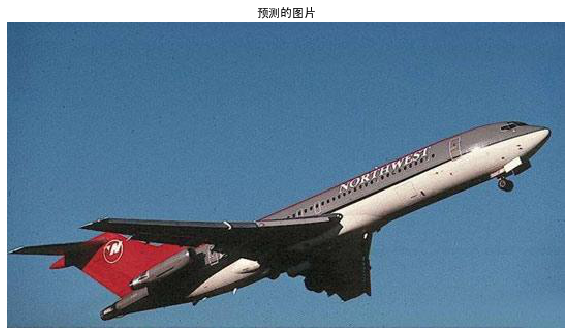

In [22]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

net = LeNet()
net.load_state_dict(torch.load('Lenet.pth'))

im = Image.open('test.jpg')
plt.figure(figsize = (10, 8))
plt.title('预测的图片')   
plt.imshow(im )
plt.axis('off')
im = transform(im)  # [C, H, W]
im = torch.unsqueeze(im, dim=0)  # [N, C, H, W]

with torch.no_grad():
    outputs = net(im)
    predict = torch.max(outputs, dim=1)[1].data.numpy()
print(f'预测的结果：{classes[int(predict)]}')